# Data Cleaning

The following section will focus on the data cleaning.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta

We will initially load in the base dataset.

In [52]:
bank_data = '../Data/bank-additional-full.csv'

In [53]:
data = pd.read_csv(bank_data, sep = ';')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [55]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [56]:
data.reset_index(inplace=True)

In [57]:
data.head()

,index,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Creating a Date Column

The dataset that we are working with as a column for 3m EURIBOR. EURIBOR is the Euro Interbank Offer Rate. The fixing is published daily (exluding weekends and European Bank holidays) by the European Money Markets Institute. In this section, we will look to source the 3m EURIBOR fixings for the period that we have in our dataset. Using this rate, and the date index, we will be able to backward engineer a date index column for our original data set.

We have sourced the 3m EURIBOR fixings from the following website as a CSV. The original CSV downloaded can be found in the Data folder.

http://iborate.com/eur-libor/

In [105]:
#Reading in the CSV file and saving it under the euribor variable.
euribor = pd.read_csv('../Data/LIBOR EUR.csv')
euribor = euribor[['Date','3M']]

Here we will set the Date column as date time, and convert it into a string so that we can select the 3m EURIBOR fixing to the same number of decimnal places as we have on our orginal dataset.

In [106]:
#Setting the Date column as datetime and converting it to a string.
euribor['Date'] = pd.to_datetime(euribor['Date'])
euribor['3M'] = euribor['3M'].astype(str)

EURIBOR can have the same reading over multiple dates. We will drop the duplicates so that we only have 1 unique EURIBOR fixing for each date.

In [107]:
#Dropping duplicates.
euribor.drop_duplicates(subset ="3M", keep = 'first', inplace = True)

In [108]:
#Creating a new column euribor3m (same as the column name for the original data set) and selecting it up to 3 decimal places using the lambda function.
euribor['euribor3m'] = euribor['3M'].apply(lambda x: x[0:5])

In [109]:
#Checking the head.
euribor.head()

,Date,3M,euribor3m
0,2010-11-30,0.9675,0.967
2,2010-11-26,0.96875,0.968
5,2010-11-23,0.97375,0.973
6,2010-11-22,0.97625,0.976
7,2010-11-19,0.97875,0.978


In [110]:
#Sorting the dataframe by the euribor3m column.
euribor.sort_values(by='euribor3m', ascending=False)

,Date,3M,euribor3m
549,2008-08-10,5.39125,5.391
548,2008-09-10,5.38625,5.386
550,2008-07-10,5.37125,5.371
547,2008-10-10,5.36625,5.366
551,2008-06-10,5.3375,5.337
...,...,...,...
159,2010-04-20,0.5818800000000001,0.581
166,2010-09-04,0.58063,0.580
172,2010-03-30,0.58,0.58
171,2010-03-31,0.5775,0.577


In [111]:
#Changing the column back into a float.
euribor['euribor3m'] = euribor['euribor3m'].astype(float)

We will now create a merged dataframe using our original dataset and the 3m EURIBOR rates that we have sourced independently. We will use pandas merge function to carry out a left join on the dataframes, using euribor3m column as the common index. This will be saved under data2.

In [114]:
#Creating a merged dataframe using left join, on column euribor3m.
data2= pd.merge(data,euribor, on='euribor3m', how='left')

In [115]:
#Setting the 3M column as a float.
data2['3M'] = data2['3M'].astype(float)

In [116]:
#Checking the data2 info.
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49283 entries, 0 to 49282
Data columns (total 24 columns):
index             49283 non-null int64
age               49283 non-null int64
job               49283 non-null object
marital           49283 non-null object
education         49283 non-null object
default           49283 non-null object
housing           49283 non-null object
loan              49283 non-null object
contact           49283 non-null object
month             49283 non-null object
day_of_week       49283 non-null object
duration          49283 non-null int64
campaign          49283 non-null int64
pdays             49283 non-null int64
previous          49283 non-null int64
poutcome          49283 non-null object
emp.var.rate      49283 non-null float64
cons.price.idx    49283 non-null float64
cons.conf.idx     49283 non-null float64
euribor3m         49283 non-null float64
nr.employed       49283 non-null float64
y                 49283 non-null object
Date        

Now that this is done, we can check to see if the new dataframe, data2, has any null values. The number of rows has increased from 41,188 to 49,283. This will be because extra rows were created during the merge. 

In [117]:
data2.isna().sum()

index                 0
age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
Date              21021
3M                21021
dtype: int64

Our original dataset does not have any null values, however the columns from the euribor dataframe has 21,021 columns. This is likely due to differences in rounding methods used by the data sources.

We will now drop the duplicates in the index column and keep the first.

In [119]:
#Dropping duplicates.
data2.drop_duplicates(subset ="index", keep = 'first', inplace = True) 

In [120]:
#Checking to see if this worked.
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 49282
Data columns (total 24 columns):
index             41188 non-null int64
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
Date        

In order to see if our data has merged correctly, we will plot the 3m EURIBOR columns from the 2 data sources over each other.

In [121]:
data2.set_index('Date',inplace=True)
euribor.set_index('Date',inplace=True)
euribor['3M'] = euribor['3M'].astype(float)

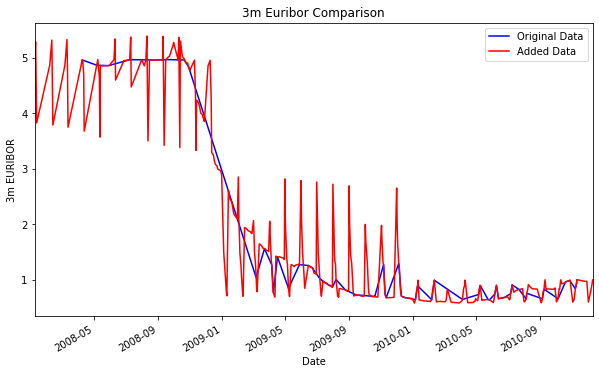

In [122]:
plt.figure(figsize=(10,6))
data2['euribor3m'].plot(color='blue', label='Original Data')
euribor['3M'].plot(color='red', label='Added Data')
plt.xlabel('Date')
plt.ylabel('3m EURIBOR')
plt.title('3m Euribor Comparison')
plt.legend()
plt.show()

The two EURIBOR columns largely overlap with each other, we are happy with this and can proceed to the next step.

In [123]:
data2.drop(columns='3M', inplace=True)

In [124]:
data2.head()

,index,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-29,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008-05-29,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008-05-29,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008-05-29,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008-05-29,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [125]:
data2.reset_index(inplace=True)

In [126]:
len(data2['Date'].unique())

78

In [127]:
data3 = data2.copy()

In [128]:
data2.head()

,Date,index,age,job,marital,education,default,housing,loan,contact,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,2008-05-29,0,56,housemaid,married,basic.4y,no,no,no,telephone,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2008-05-29,1,57,services,married,high.school,unknown,no,no,telephone,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2008-05-29,2,37,services,married,high.school,no,yes,no,telephone,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,2008-05-29,3,40,admin.,married,basic.6y,no,no,no,telephone,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,2008-05-29,4,56,services,married,high.school,no,no,yes,telephone,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [129]:
data2.Date.isna().sum()

21021

As 3m EURIBOR is fixes daily, the day-to-day fixing is usually similar to each other. In order to address the issue caused by rounding, we can simply look to forward fill the missing dates. The risk of this however, is that it could put some of the dates into the weekend (Saturday or Sunday). We would need to address this by bringing those dates back into the business week.

In [130]:
#Forward filling the data using pandas.
data3['Date'] = data3['Date'].ffill()

In [131]:
#Checking to see if the dates have been filled correctly.
data3['Date'].isna().sum()

0

In [132]:
#Checking to see if the dataframe looks correct now.
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
Date              41188 non-null datetime64[ns]
index             41188 non-null int64
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y   

We will now create a new column called day_week, and assign the day of the week to the dataframe.

In [133]:
#Creating a new column day_week
data3['day_week'] = data3['Date'].dt.weekday_name

In [134]:
# 
xp = data3.loc[data3['day_week']=='Saturday']

In [135]:
xp['Date'].unique()

array(['2008-09-06T00:00:00.000000000', '2009-12-05T00:00:00.000000000',
       '2010-07-10T00:00:00.000000000', '2010-08-07T00:00:00.000000000',
       '2010-02-06T00:00:00.000000000', '2009-03-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [136]:
xy = xp = data3.loc[data3['day_week']=='Sunday']

In [137]:
xy['Date'].unique()

array(['2010-01-10T00:00:00.000000000'], dtype='datetime64[ns]')

In [138]:
data3['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [139]:
data3[['day_week','day_of_week']]

,day_week,day_of_week
0,Thursday,mon
1,Thursday,mon
2,Thursday,mon
3,Thursday,mon
4,Thursday,mon
...,...,...
41183,Saturday,fri
41184,Saturday,fri
41185,Saturday,fri
41186,Saturday,fri


In [141]:
data3['Date'][1]

Timestamp('2008-05-29 00:00:00')

In [142]:
data3['Date'][1] - timedelta(1)

Timestamp('2008-05-28 00:00:00')

Now that we have identified which days are Saturdays and Sundays, we can manually adjust these dates. We will reduce the Saturdays by 1 day, and the Sundays by 2 days in order to bring them back into the working week.

In [143]:
#Adjusting the days.
data3.loc[(data3['day_week'] =='Saturday'),'Date'] = data3['Date'] - timedelta(1)
data3.loc[(data3['day_week'] =='Sunday'),'Date'] = data3['Date'] - timedelta(2)

In [144]:
data3['day_week'] = data3['Date'].dt.weekday_name

In [145]:
data3['day_week'].unique()

array(['Thursday', 'Wednesday', 'Monday', 'Friday', 'Tuesday'],
      dtype=object)

In [147]:
#Dropping the columns we do not need.
data3.drop(['day_week'], axis=1, inplace=True)

In [148]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
Date              41188 non-null datetime64[ns]
index             41188 non-null int64
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y   

## Sourcing additional economic data and merging it with our dataframe

We now have the original data frame with a date index. Using this date index will allow us to add any additional economic data we want to make a stronger prediction model.

We have sourced additional data from the trading economics website and saved this under a CSV called Portugal_Eurozone_data.csv. In this section we will look to merge this additional data along with our original dataframe currently saved under data3.

In [149]:
#Reading in the CSV file.
additional_data = pd.read_csv('../Data/Portugal_Eurozone_data.csv')

In [150]:
#Setting the column names of this dataframe as the first row.
headers = additional_data.iloc[0]
additional_data  = pd.DataFrame(additional_data.values[1:], columns=headers)

In [151]:
#Saving the date column as datatime format.
additional_data['Date'] = pd.to_datetime(additional_data['Date'])

In [152]:
#Checking to see if this worked.
additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 11 columns):
Date                               783 non-null datetime64[ns]
MOM Inflation                      783 non-null object
Wage Growth                        783 non-null object
EURUSD                             783 non-null object
euro zoneGDP Growth Rate           783 non-null object
Portugal Income Tax annual rate    783 non-null object
Portugal Bank Lending Rate         783 non-null object
Portugal Personal Savings          783 non-null object
Portugal Wages                     783 non-null object
Portugal Unemployment Rate         783 non-null object
Portugal Sales Tax                 783 non-null object
dtypes: datetime64[ns](1), object(10)
memory usage: 67.4+ KB


Now that we have the new data in the format we want saved under additional_data, we will look to use a left merge on the Data column of original dataframe data3.

In [153]:
#Merging the dataframes.
data_final= pd.merge(data3,additional_data, on='Date', how='left')

In [154]:
#Checking to see if this worked.
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 33 columns):
Date                               41188 non-null datetime64[ns]
index                              41188 non-null int64
age                                41188 non-null int64
job                                41188 non-null object
marital                            41188 non-null object
education                          41188 non-null object
default                            41188 non-null object
housing                            41188 non-null object
loan                               41188 non-null object
contact                            41188 non-null object
month                              41188 non-null object
day_of_week                        41188 non-null object
duration                           41188 non-null int64
campaign                           41188 non-null int64
pdays                              41188 non-null int64
previous                         

In [155]:
#Checking for null values.
data_final.isna().sum()

Date                               0
index                              0
age                                0
job                                0
marital                            0
education                          0
default                            0
housing                            0
loan                               0
contact                            0
month                              0
day_of_week                        0
duration                           0
campaign                           0
pdays                              0
previous                           0
poutcome                           0
emp.var.rate                       0
cons.price.idx                     0
cons.conf.idx                      0
euribor3m                          0
nr.employed                        0
y                                  0
MOM Inflation                      0
Wage Growth                        0
EURUSD                             0
euro zoneGDP Growth Rate           0
P

Our data looks okay, however to verify this, we will plot some of the new columns against the date to see if it looks accurate.

In [156]:
#Saving the Date column under the datetime index.
data_final['Date'] = pd.to_datetime(data_final['Date'])

In [157]:
data_final.set_index('Date', inplace=True)

In [158]:
data_final_list = list(data_final.columns)

In [159]:
data_list = data_final_list[-10:]

In [160]:
data_final[data_list] = data_final[data_list].astype(float)

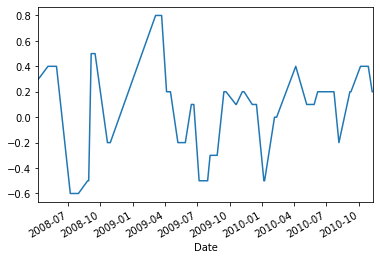

In [161]:
data_final['MOM Inflation'].plot()

We are happy with our merged dataframe. We can now save this under the CSV data_final located in the Data folder. We will then be able to move onto Feature Engineering in the next notebook.

In [163]:
#Saving the dataframe.
data_final.to_csv('../Data/data_final.csv')